<a href="https://colab.research.google.com/github/Payal2000/Data-Science-Assignments-INFO6105/blob/main/Assignment_2_AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast Cancer Prediction using H2O Auto ML

## Abstract
## What is our ultimate aim with this notebook?

Our ultimate aim is to build a machine learning model using H2O Auto ML that can predict if the person is suffering from Breast Cancer Prediction based on several medical parameters as mentioned below.

### **Column Description for our Dataset**

Kaggle Dataset Link:

## **Setup**

### Let’s import the necessary packages

In [1]:
##Installing all the required libraries for the Assignment
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install h2o

In [2]:
# Importing all the libararies required for the assignment
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

sns.set(rc={"figure.figsize": (16, 8)})

Description of few important libraries

1. **h2o** - h2o is a fast, open-source, in-memory, distributed, advanced analytics and modeling engine. It supports GLMs, gradient boosting, random forests, deep learning, and automatic machine learning.

2. **pprint** is a library for pretty-printing data structures.

3. **operator** provides functions to perform operations on sequences, such as sorting.

4. **matplotlib** is a plotting library for creating charts, graphs, and other visualizations.

5. **tabulate** is a library for creating tables in various formats.

6. **logging** is a library for emitting log messages from applications.

7. **optparse** is a library for parsing command-line options.

8. **psutil** is a library for retrieving information on system utilization (CPU, memory, disks, network, sensors) and on running processes and system uptime.

In [3]:
# Setting up maximum runtime for the AutoML
min_mem_size = 6
run_time = 222

### **Why do we have to set runtime?**

The value set for the maximum runtime in AutoML will depend on a variety of factors, including the size and complexity of your dataset, the number of models and hyperparameters you want to explore, and the computational resources available to you.Setting a runtime limit is an important for managing resources and optimizing the efficiency of the machine learning process in AutoML Also you can change the runtime values and check the model performance

**min_mem_size = 6** typically refers to the minimum amount of memory (in gigabytes) that is required to run a particular software or process. It means that the system running the software or process must have at least 6 GB of available memory in order to run it without encountering memory-related issues.

In [4]:
#Calculating the minimum amount of memeory required
pct_memory = 0.5
virtual_memory = psutil.virtual_memory()
min_mem_size = int(round(int(pct_memory * virtual_memory.available) / 1073741824, 0))
print(min_mem_size)

6


Note :psutil library is used to retrieve system information, and must be installed

## **Initialize the H2O cluster**

In [5]:
# 65535 Highest port no
#generating a random port number between 5555 and 55555, which will be used to start the H2O server
port_no = random.randint(5555, 55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
    h2o.init(
        strict_version_check=False, min_mem_size_GB=min_mem_size, port=port_no
    )  # start h2o
except:
    logging.critical("h2o.init")
    h2o.download_all_logs(dirname=logs_path, filename=logfile)
    h2o.cluster().shutdown()
    sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:30261..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20.1" 2023-08-24; OpenJDK Runtime Environment (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp200xwl3c
  JVM stdout: /tmp/tmp200xwl3c/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp200xwl3c/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:30261
Connecting to H2O server at http://127.0.0.1:30261 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.4
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_unknownUser_zaj9yu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


The parameter strict_version_check is used to control whether H2O performs strict version checking between the H2O client and server. If strict_version_check=True, H2O will check whether the versions of the H2O client and server match exactly, and will raise an error if they don't. If strict_version_check=False, H2O will perform a more lenient version check, allowing minor version mismatches.



In [16]:
# Reading CSV file into Pandas DataFrame
pandas_df = pd.read_csv(
    "https://raw.githubusercontent.com/Payal2000/Data-Science-Assignments-INFO6105/main/new_model.csv"
)

## **Performing EDA**

In [7]:
#Printing the summary of the dataframe for our Analysis like data types,null values and memory usage
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [8]:
#Checking missing values in our data
pandas_df.isnull().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

## Observations:

We have 0% missing values both in our independent variables as well as dependent variable

In [9]:
# Printing Shape of the dataframe
pandas_df.shape

(569, 32)

In [10]:
#Reading first 5 rows of data frame
pandas_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [11]:
# Printing the name of all predictors and result
columns = list(pandas_df.columns)
print(columns)

['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [12]:
# Statistical description of our dataset
pandas_df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


<ipython-input-13-2ba70e41149e>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pandas_df.corr(), annot=True, cmap="Blues"


<Axes: >

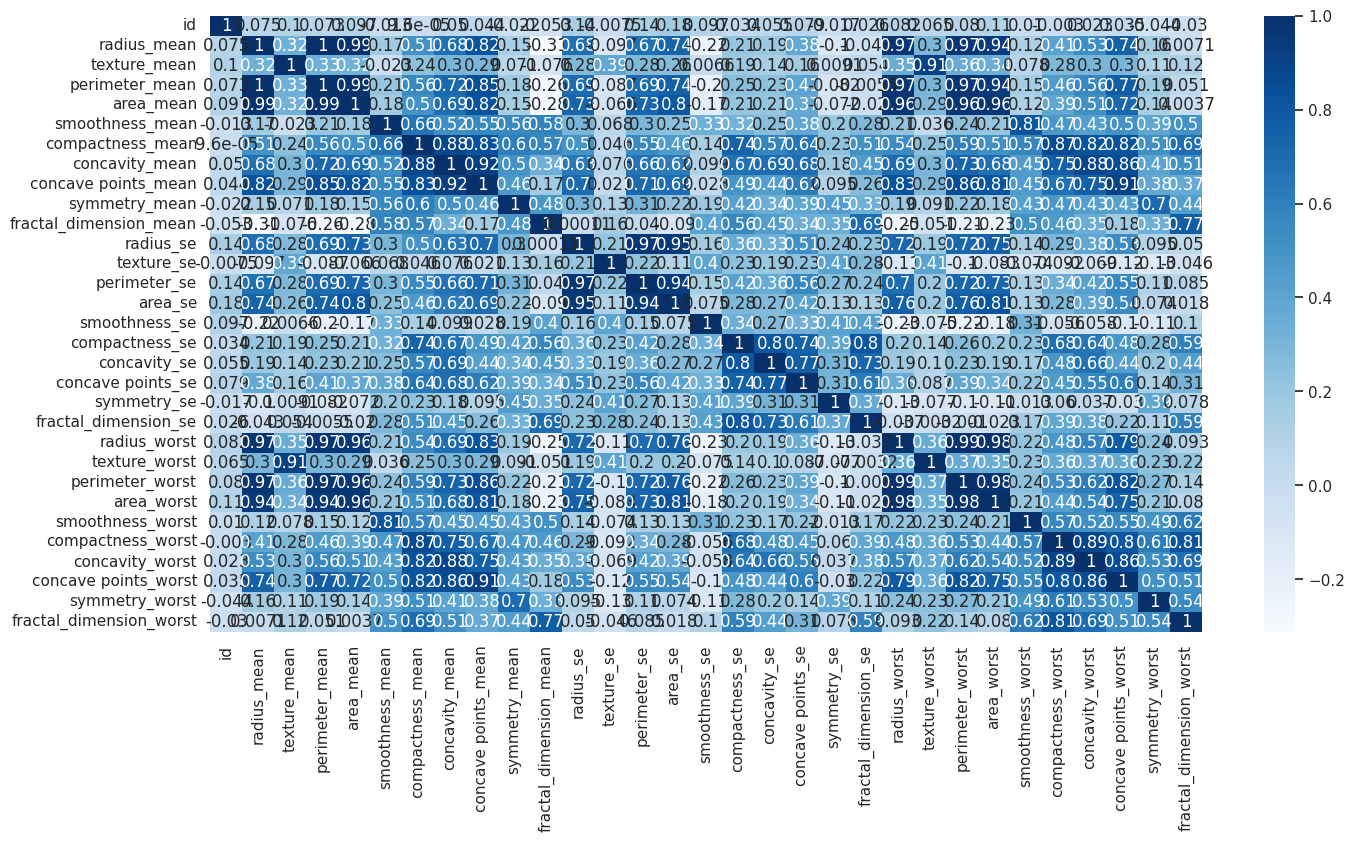

In [13]:
# Heatmap showing correlation between the attributes.
sns.heatmap(
    pandas_df.corr(), annot=True, cmap="Blues"
)

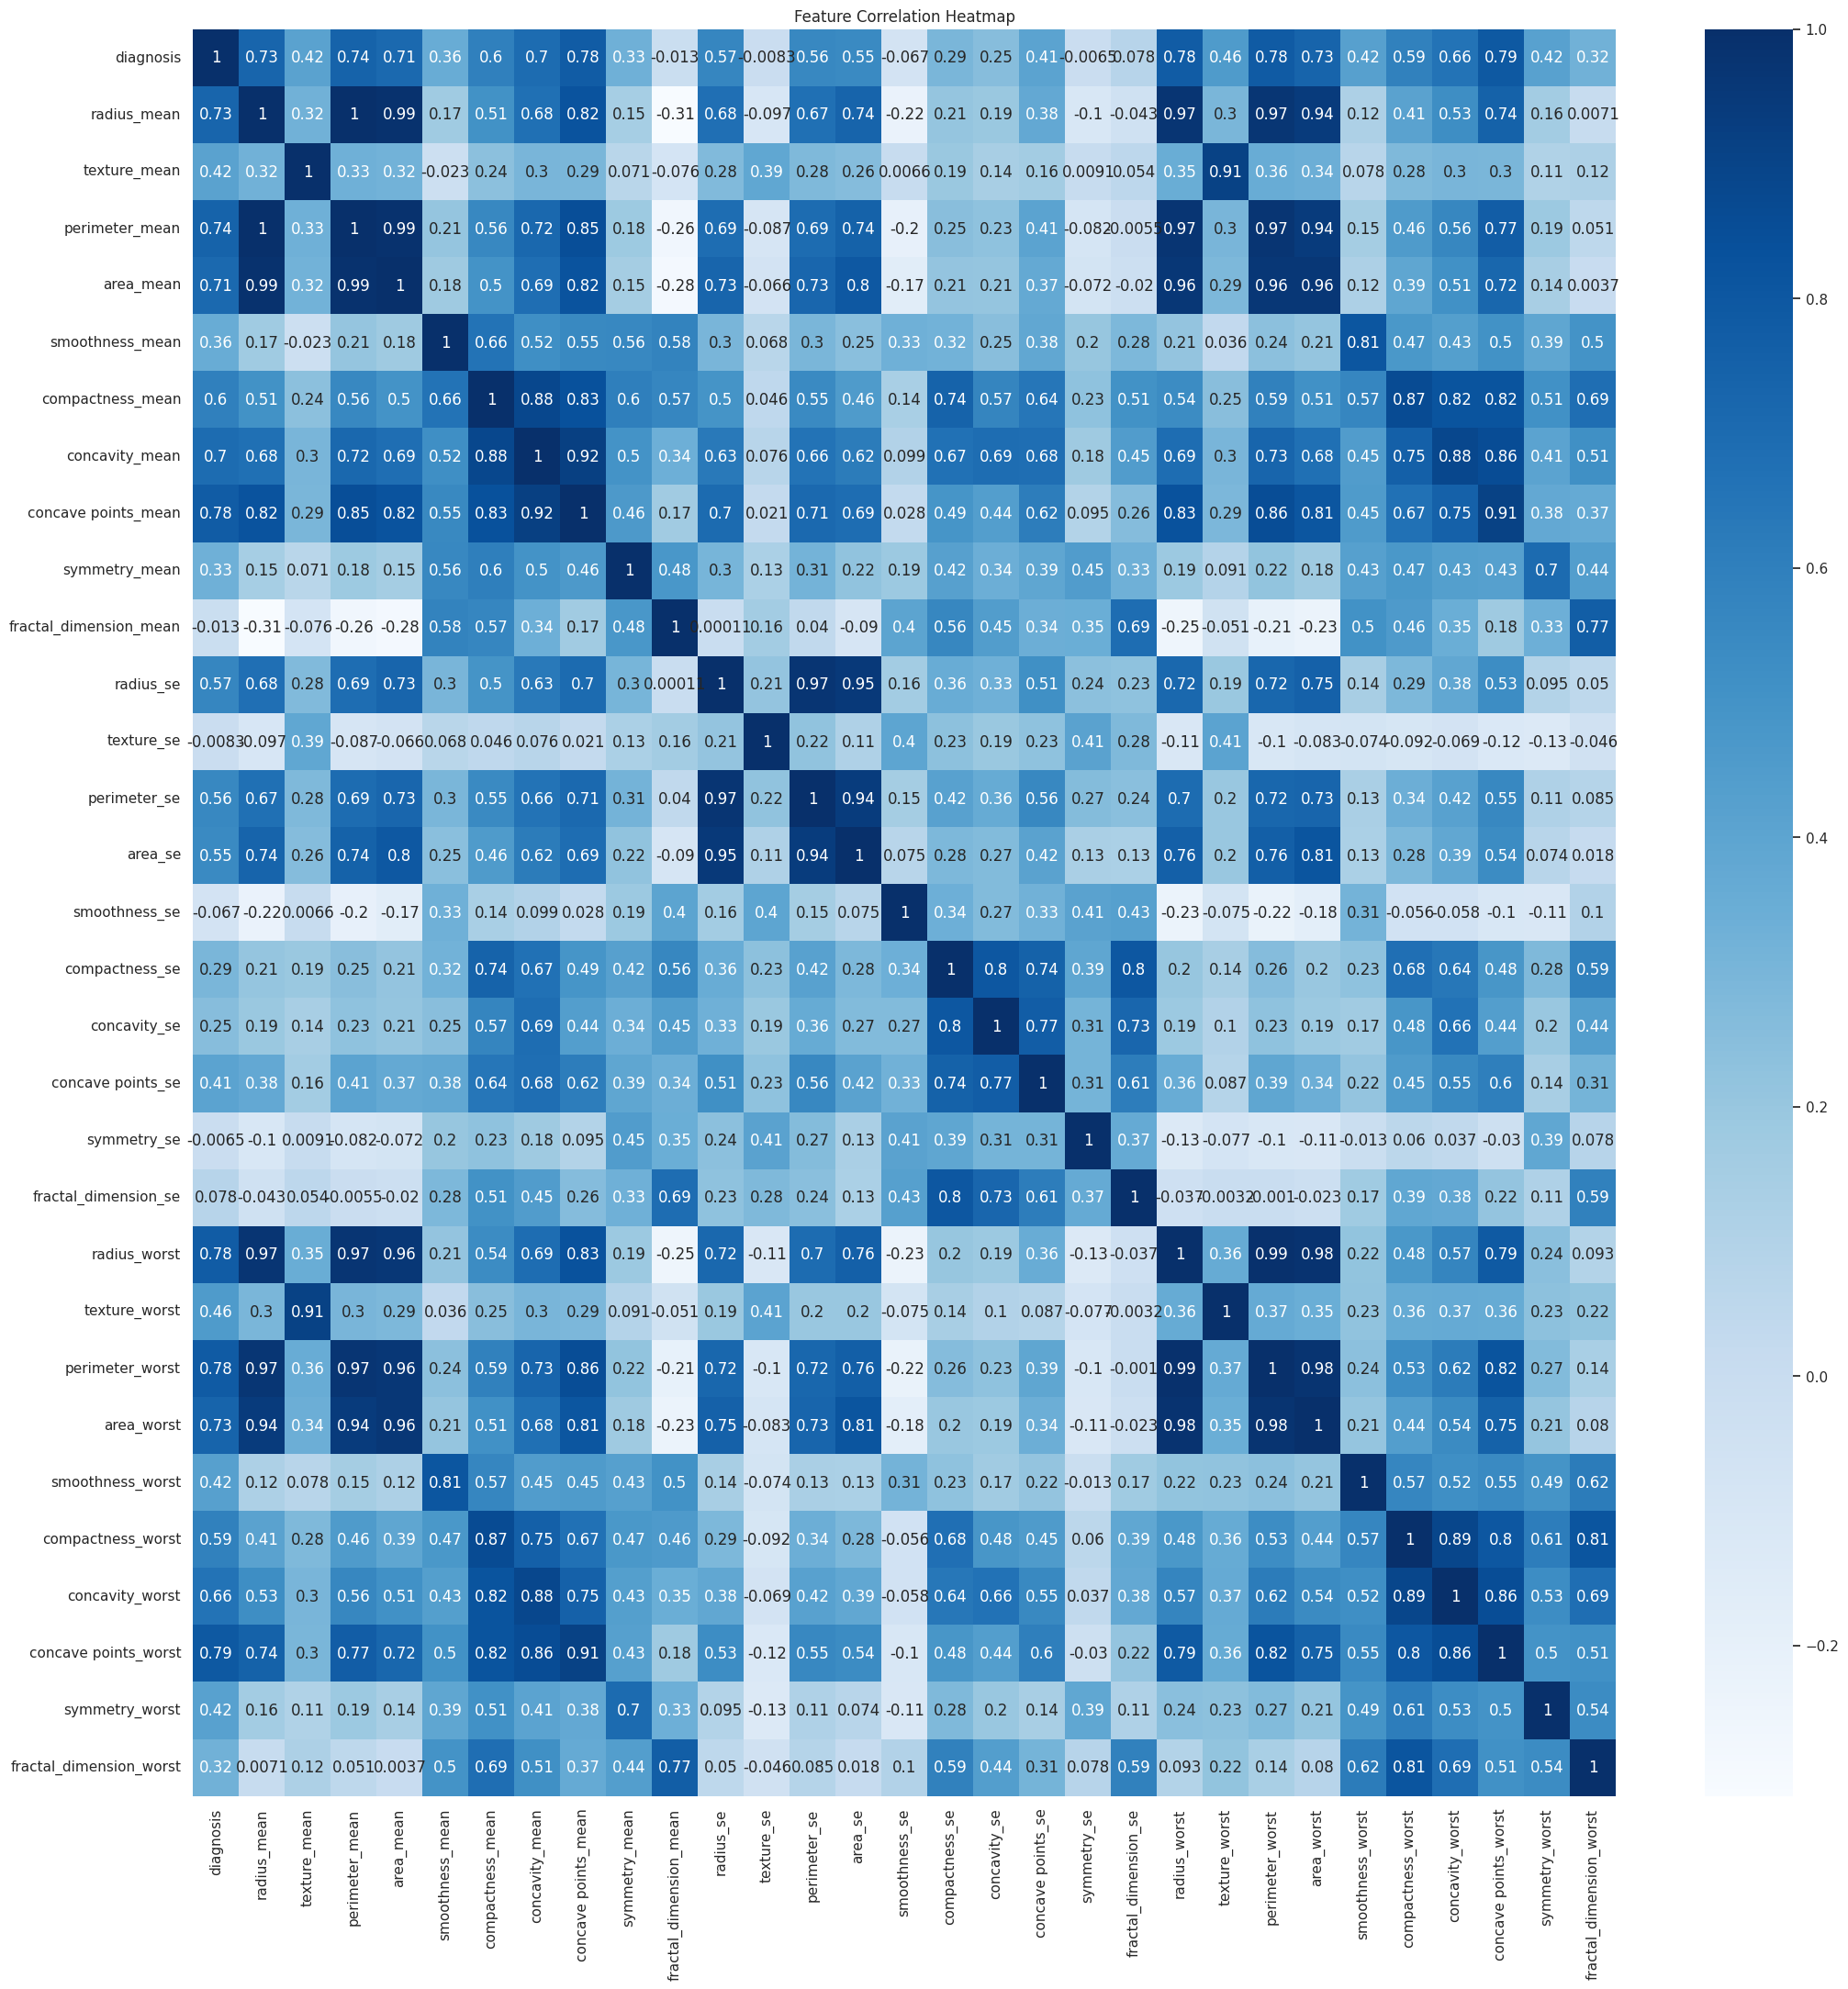

In [14]:

# Drop the 'id' column as it is just an identifier and does not contribute to correlation
pandas_df.drop('id', axis=1, inplace=True)

# Convert diagnosis column to a numerical value for correlation calculation (M=1, B=0)
pandas_df['diagnosis'] = pandas_df['diagnosis'].map({'M': 1, 'B': 0})

# Compute the correlation matrix
correlation_matrix = pandas_df.corr()

# Generate a heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(correlation_matrix, annot=True, cmap="Blues")
plt.title('Feature Correlation Heatmap')
plt.show()

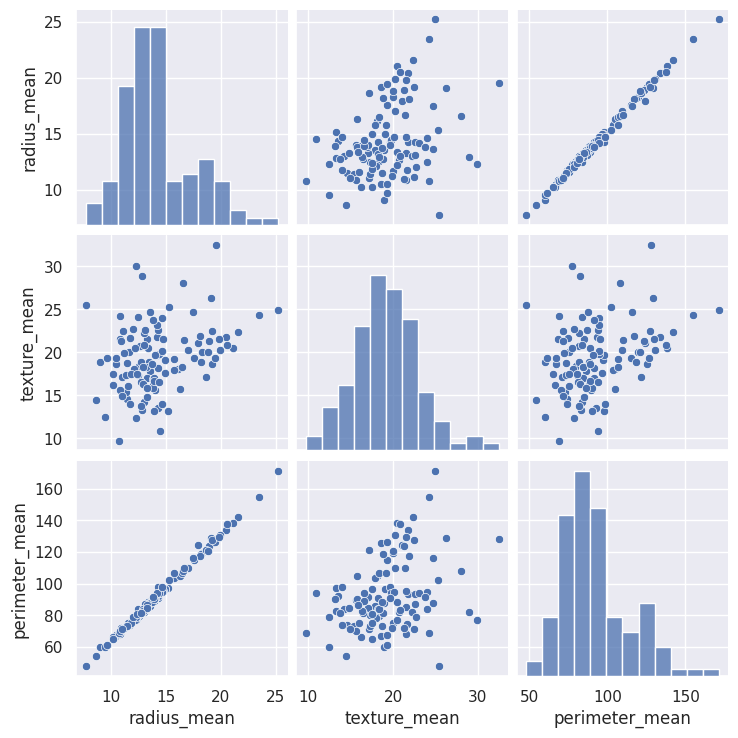

In [18]:
# Sample 20% of the data
sample_df = pandas_df.sample(frac=0.2)

# Select only a subset of the features
selected_features = ['radius_mean', 'texture_mean', 'perimeter_mean']

sns.pairplot(sample_df[selected_features])
plt.show()



As the dataset is large, it was taking me alot of time to compute

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'radius_mean'}>,
        <Axes: title={'center': 'texture_mean'}>,
        <Axes: title={'center': 'perimeter_mean'}>,
        <Axes: title={'center': 'area_mean'}>,
        <Axes: title={'center': 'smoothness_mean'}>],
       [<Axes: title={'center': 'compactness_mean'}>,
        <Axes: title={'center': 'concavity_mean'}>,
        <Axes: title={'center': 'concave points_mean'}>,
        <Axes: title={'center': 'symmetry_mean'}>,
        <Axes: title={'center': 'fractal_dimension_mean'}>,
        <Axes: title={'center': 'radius_se'}>],
       [<Axes: title={'center': 'texture_se'}>,
        <Axes: title={'center': 'perimeter_se'}>,
        <Axes: title={'center': 'area_se'}>,
        <Axes: title={'center': 'smoothness_se'}>,
        <Axes: title={'center': 'compactness_se'}>,
        <Axes: title={'center': 'concavity_se'}>],
       [<Axes: title={'center': 'concave points_se'}>,
        <Axes: title={'center': 's

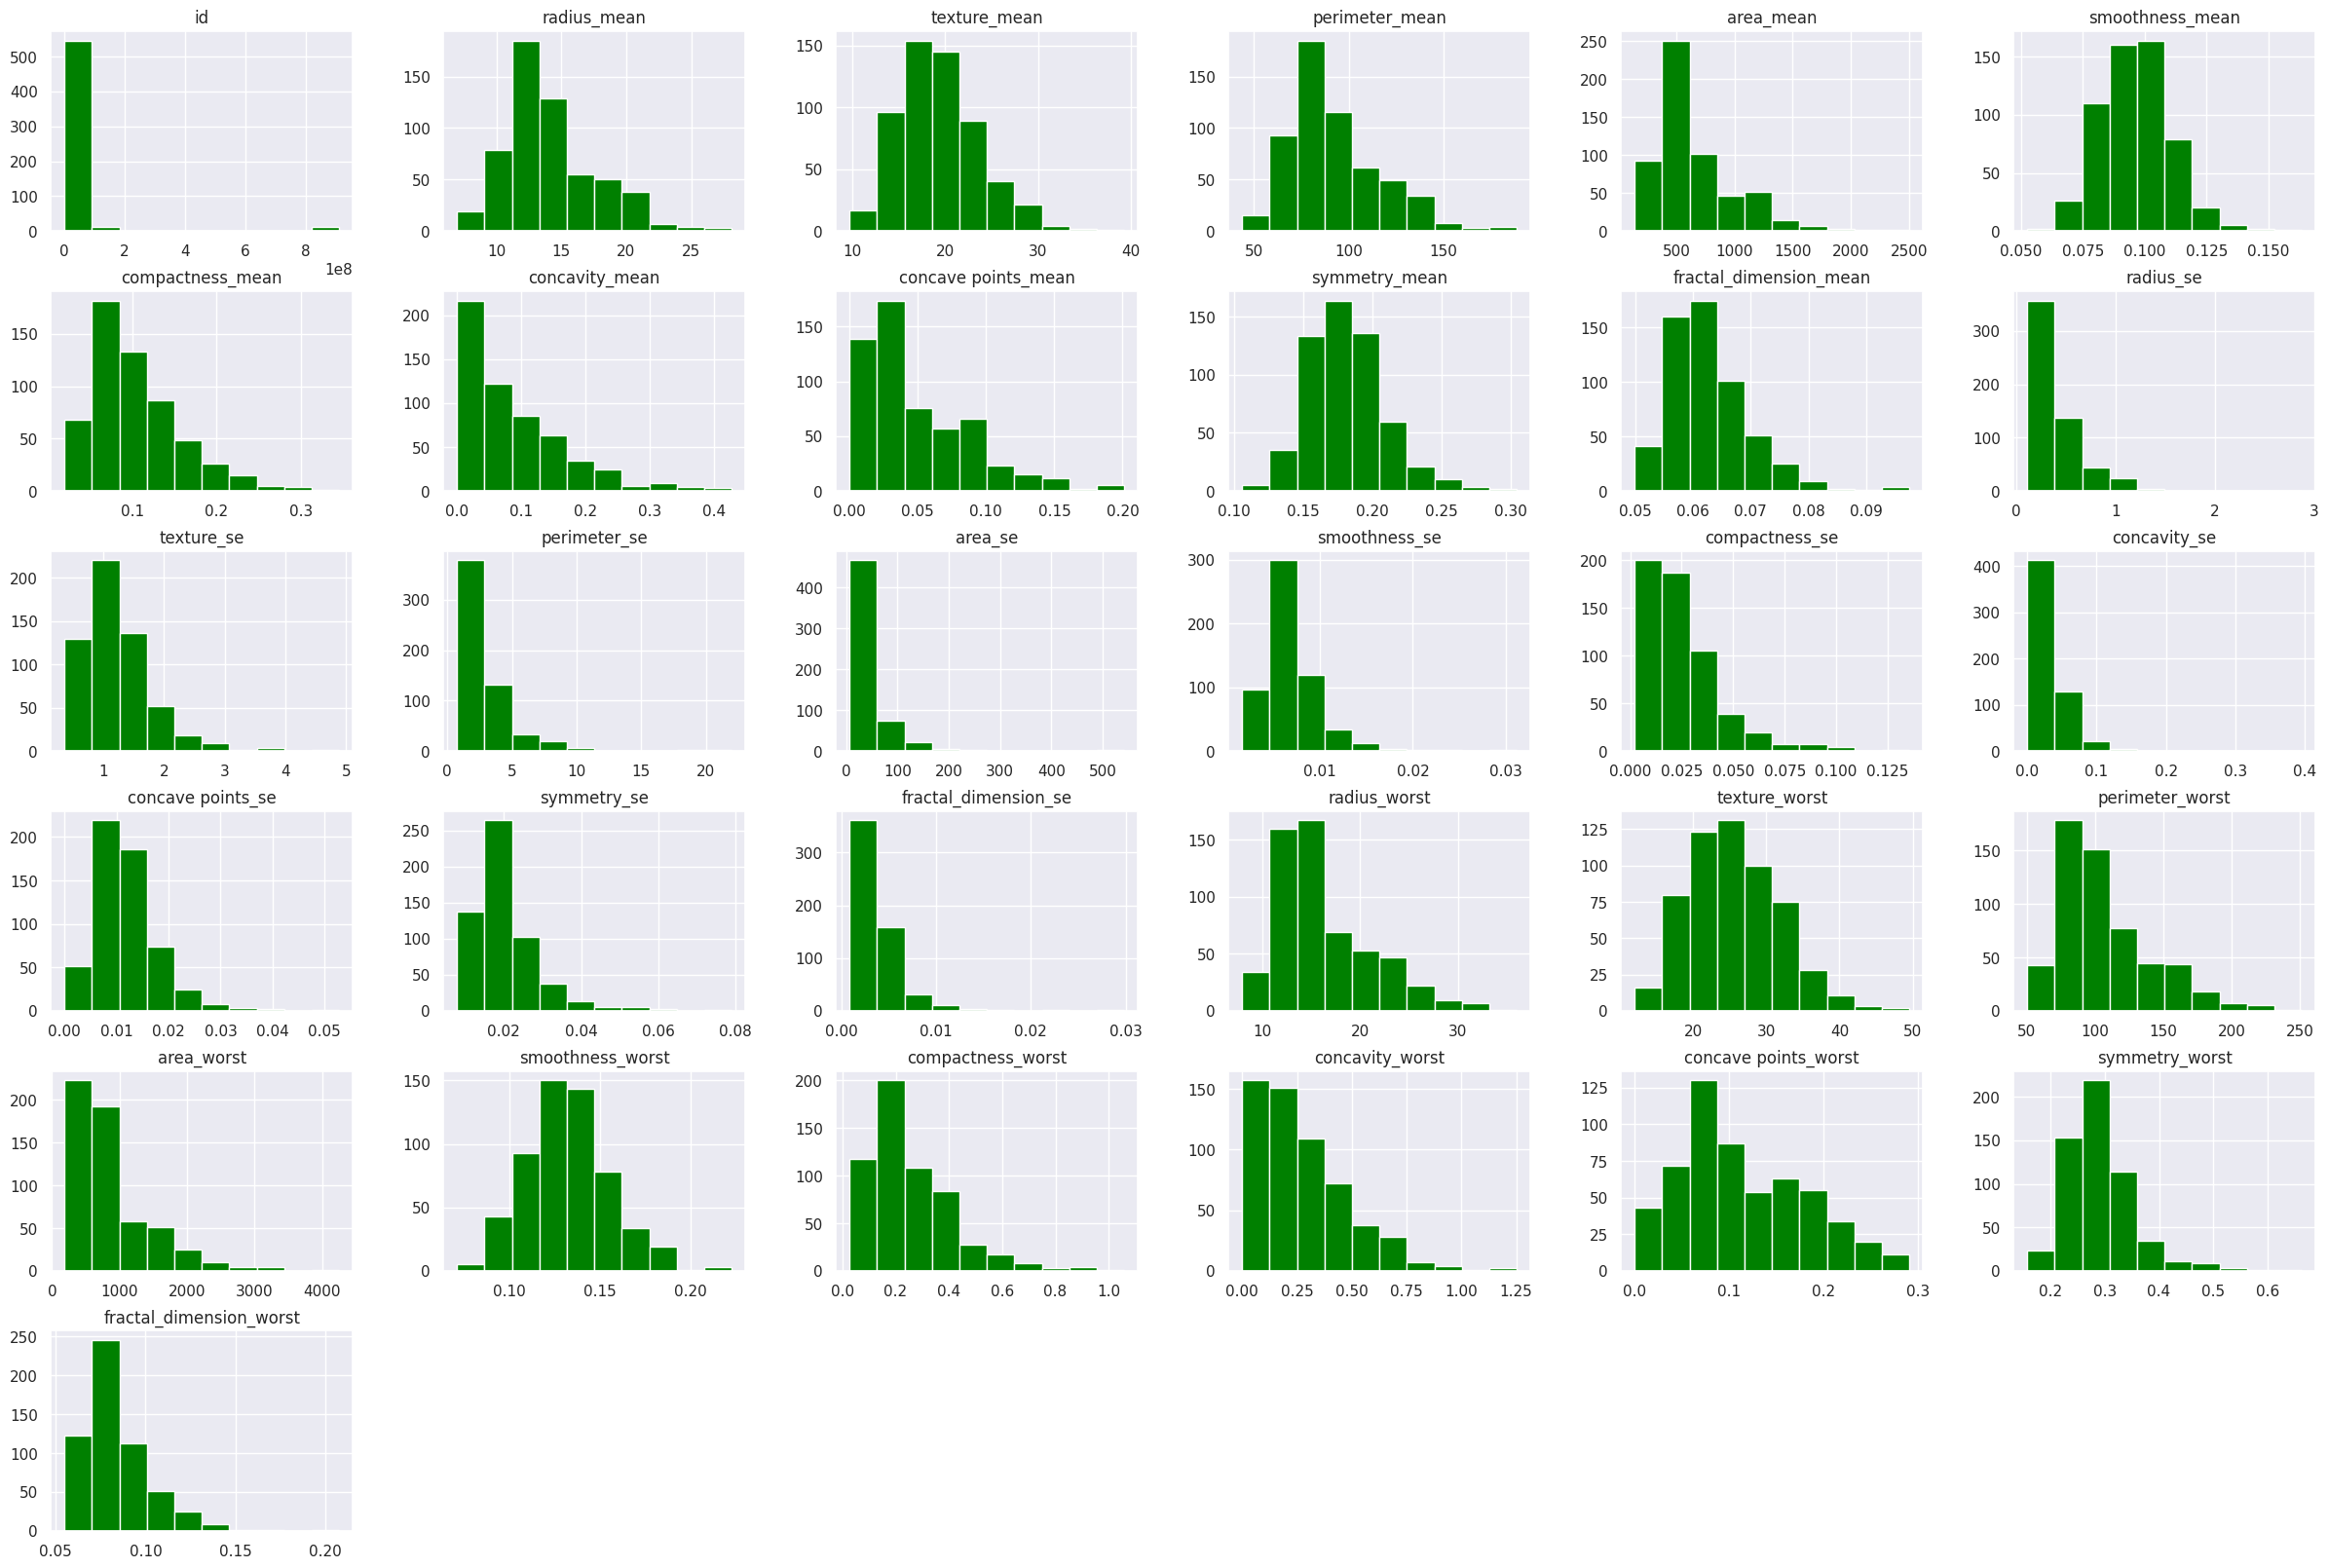

In [22]:
# Plotted Histogram
pandas_df.hist(color="green", figsize=(30, 20))

# **Identifing predictor significance**

In [23]:
import statsmodels.api as sm

# Convert diagnosis column to numerical (M=1, B=0)
pandas_df['diagnosis'] = pandas_df['diagnosis'].map({'M': 1, 'B': 0})

# Define independent variables (features) and dependent variable (response)
X = pandas_df[['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean']]
y = pandas_df['diagnosis']

# Add a constant to the model
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

# Print out the statistics
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              diagnosis   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     205.9
Date:                Fri, 06 Oct 2023   Prob (F-statistic):          1.40e-124
Time:                        08:17:32   Log-Likelihood:                -98.039
No. Observations:                 569   AIC:                             208.1
Df Residuals:                     563   BIC:                             234.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.4931      0.217    -

## Is the relationship significant?

1. radius_mean has a p-value of 0.843 which is greater than 0.05, so it is not a significant feature.

2. texture_mean has a p-value of 0.000 which is lesser than 0.05, so it is a significant feature.

3. perimeter_mean has a p-value of 0.005 which is lesser than 0.05, so it is a significant feature.

4. area_mean has a p-value of 0.000 which is lesser than 0.05, so it is a significant feature.

5. smoothness_mean has a p-value of 0.000 which is lesser than 0.05, so it is a significant feature.

The relationship is significant when the p-value for the predictor variables is less than 0.05. If it is higher than 0.05, the result is non-significant. From the OLS method, the variables "texture_mean", "perimeter_mean", "area_mean", and "smoothness_mean" have p-values less than 0.05, indicating that they are statistically significant in the model. Any change in these variables has a significant impact on the target variable (diagnosis).

However, the variable "radius_mean" is not significant, indicating that, within the context of this model, changes in this variable might not significantly affect the diagnosis.

Therefore, for the breast cancer dataset, we can conclude that the relationship is significant for most of the features selected in the model, but not all.







## **VIF(multicollinearity)**

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Indicate which variables to compute VIF for
# Note: From the dataset you've shared, I've chosen a subset of features for the VIF computation. Feel free to include or exclude features as you see fit.
features = pandas_df[['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean']]

# Compute VIF
vif = pd.DataFrame()
vif["variables"] = features.columns
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print(vif)


         variables          VIF
0      radius_mean  3526.872924
1     texture_mean    22.329552
2   perimeter_mean  4527.360366
3        area_mean    89.413301
4  smoothness_mean    49.764471


In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Remove non-numeric features like 'id' and target variable 'diagnosis' for VIF computation.
features = pandas_df.drop(columns=['id', 'diagnosis'])

# Compute VIF
vif = pd.DataFrame()
vif["variables"] = features.columns
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print(vif)


                  variables           VIF
0               radius_mean  63306.172036
1              texture_mean    251.047108
2            perimeter_mean  58123.586079
3                 area_mean   1287.262339
4           smoothness_mean    393.398166
5          compactness_mean    200.980354
6            concavity_mean    157.855046
7       concave points_mean    154.241268
8             symmetry_mean    184.426558
9    fractal_dimension_mean    629.679874
10                radius_se    236.665738
11               texture_se     24.675367
12             perimeter_se    211.396334
13                  area_se     72.466468
14            smoothness_se     26.170243
15           compactness_se     44.919651
16             concavity_se     33.244099
17        concave points_se     53.698656
18              symmetry_se     37.176452
19     fractal_dimension_se     27.532631
20             radius_worst   9674.742602
21            texture_worst    343.004387
22          perimeter_worst   4487

VIF stands for Variance Inflation Factor. It signifies multicollinearity among a set of different independent variables. A VIF value greater than 10 indicates that the independent variable is highly correlated with other variables in the set. We have calculated VIF values for all variables to check for multicollinearity.

From these values, the variables radius_mean, perimeter_mean, area_mean, radius_worst, and perimeter_worst have VIF values significantly greater than 10, suggesting they are highly correlated with other variables in the dataset.

In [26]:
# Converted Pandas Dataframe to H2O dataframe to proceed with AutoML
df = h2o.H2OFrame(
    pandas_df
)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [27]:
df.types

{'id': 'int',
 'diagnosis': 'int',
 'radius_mean': 'real',
 'texture_mean': 'real',
 'perimeter_mean': 'real',
 'area_mean': 'real',
 'smoothness_mean': 'real',
 'compactness_mean': 'real',
 'concavity_mean': 'real',
 'concave points_mean': 'real',
 'symmetry_mean': 'real',
 'fractal_dimension_mean': 'real',
 'radius_se': 'real',
 'texture_se': 'real',
 'perimeter_se': 'real',
 'area_se': 'real',
 'smoothness_se': 'real',
 'compactness_se': 'real',
 'concavity_se': 'real',
 'concave points_se': 'real',
 'symmetry_se': 'real',
 'fractal_dimension_se': 'real',
 'radius_worst': 'real',
 'texture_worst': 'real',
 'perimeter_worst': 'real',
 'area_worst': 'real',
 'smoothness_worst': 'real',
 'compactness_worst': 'real',
 'concavity_worst': 'real',
 'concave points_worst': 'real',
 'symmetry_worst': 'real',
 'fractal_dimension_worst': 'real'}

In [28]:
# Setting up the data split between training and test dataset.
pct_rows = 0.80
df_train, df_test = df.split_frame([pct_rows])

In [29]:
#printing shapes
print(df_train.shape)
print(df_test.shape)

(456, 32)
(113, 32)


In [30]:
#displaying the first few rows of a dataframe
df_train.head()

id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
842302,1,17.99,10.38,122.8,1001,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189
8.43009e+07,1,19.69,21.25,130,1203,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.00615,0.04006,0.03832,0.02058,0.0225,0.004571,23.57,25.53,152.5,1709,0.1444,0.4245,0.4504,0.243,0.3613,0.08758
8.43584e+07,1,20.29,14.34,135.1,1297,0.1003,0.1328,0.198,0.1043,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.01149,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.2,1575,0.1374,0.205,0.4,0.1625,0.2364,0.07678
843786,1,12.45,15.7,82.57,477.1,0.1278,0.17,0.1578,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.00751,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.4,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.1244
844359,1,18.25,19.98,119.6,1040,0.09463,0.109,0.1127,0.074,0.1794,0.05742,0.4467,0.7732,3.18,53.91,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,153.2,1606,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368
8.44582e+07,1,13.71,20.83,90.2,577.9,0.1189,0.1645,0.09366,0.05985,0.2196,0.07451,0.5835,1.377,3.856,50.96,0.008805,0.03029,0.02488,0.01448,0.01486,0.005412,17.06,28.14,110.6,897,0.1654,0.3682,0.2678,0.1556,0.3196,0.1151
8.4501e+07,1,12.46,24.04,83.97,475.9,0.1186,0.2396,0.2273,0.08543,0.203,0.08243,0.2976,1.599,2.039,23.94,0.007149,0.07217,0.07743,0.01432,0.01789,0.01008,15.09,40.68,97.65,711.4,0.1853,1.058,1.105,0.221,0.4366,0.2075
845636,1,16.02,23.24,102.7,797.8,0.08206,0.06669,0.03299,0.03323,0.1528,0.05697,0.3795,1.187,2.466,40.51,0.004029,0.009269,0.01101,0.007591,0.0146,0.003042,19.19,33.88,123.8,1150,0.1181,0.1551,0.1459,0.09975,0.2948,0.08452
846226,1,19.17,24.8,132.4,1123,0.0974,0.2458,0.2065,0.1118,0.2397,0.078,0.9555,3.568,11.07,116.2,0.003139,0.08297,0.0889,0.0409,0.04484,0.01284,20.96,29.94,151.7,1332,0.1037,0.3903,0.3639,0.1767,0.3176,0.1023
846381,1,15.85,23.95,103.7,782.7,0.08401,0.1002,0.09938,0.05364,0.1847,0.05338,0.4033,1.078,2.903,36.58,0.009769,0.03126,0.05051,0.01992,0.02981,0.003002,16.84,27.66,112,876.5,0.1131,0.1924,0.2322,0.1119,0.2809,0.06287


In [31]:
df_test.head()

id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
842517,1,20.57,17.77,132.9,1326,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186,0.0134,0.01389,0.003532,24.99,23.41,158.8,1956,0.1238,0.1866,0.2416,0.186,0.275,0.08902
8.43483e+07,1,11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744,0.4956,1.156,3.445,27.23,0.00911,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173
844981,1,13,21.82,87.5,519.8,0.1273,0.1932,0.1859,0.09353,0.235,0.07389,0.3063,1.002,2.406,24.32,0.005731,0.03502,0.03553,0.01226,0.02143,0.003749,15.49,30.73,106.2,739.3,0.1703,0.5401,0.539,0.206,0.4378,0.1072
8.461e+07,1,15.78,17.89,103.6,781,0.0971,0.1292,0.09954,0.06606,0.1842,0.06082,0.5058,0.9849,3.564,54.16,0.005771,0.04061,0.02791,0.01282,0.02008,0.004144,20.42,27.28,136.5,1299,0.1396,0.5609,0.3965,0.181,0.3792,0.1048
8.51043e+06,0,13.54,14.36,87.46,566.3,0.09779,0.08129,0.06664,0.04781,0.1885,0.05766,0.2699,0.7886,2.058,23.56,0.008462,0.0146,0.02387,0.01315,0.0198,0.0023,15.11,19.26,99.7,711.2,0.144,0.1773,0.239,0.1288,0.2977,0.07259
8.51113e+06,1,15.34,14.26,102.5,704.4,0.1073,0.2135,0.2077,0.09756,0.2521,0.07032,0.4388,0.7096,3.384,44.91,0.006789,0.05328,0.06446,0.02252,0.03672,0.004394,18.07,19.08,125.1,980.9,0.139,0.5954,0.6305,0.2393,0.4667,0.09946
852631,1,17.14,16.4,116,912.7,0.1186,0.2276,0.2229,0.1401,0.304,0.07413,1.046,0.976,7.276,111.4,0.008029,0.03799,0.03732,0.02397,0.02308,0.007444,22.25,21.4,152.4,1461,0.1545,0.3949,0.3853,0.255,0.4066,0.1059
852973,1,15.3,25.27,102.4,732.4,0.1082,0.1697,0.1683,0.08751,0.1926,0.0654,0.439,1.012,3.498,43.5,0.005233,0.03057,0.03576,0.01083,0.01768,0.002967,20.27,36.71,149.3,1269,0.1641,0.611,0.6335,0.2024,0.4027,0.09876
854002,1,19.27,26.47,127.9,1162,0.09401,0.1719,0.1657,0.07593,0.1853,0.06261,0.5558,0.6062,3.528,68.17,0.005015,0.03318,0.03497,0.009643,0.01543,0.003896,24.15,30.9,161.4,1813,0.1509,0.659,0.6091,0.1785,0.3672,0.1123
856106,1,13.28,20.28,87.32,545.2,0.1041,0.1436,0.09847,0.06158,0.1974,0.06782,0.3704,0.8249,2.427,31.33,0.005072,0.02147,0.02185,0.00956,0.01719,0.003317,17.38,28,113.1,907.2,0.153,0.3724,0.3664,0.1492,0.3739,0.1027


In [32]:
X = df.columns
print(X)

['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [33]:
# Set target and predictor variables
y = "diagnosis"
X.remove(y)  # Removing the result frm our predictors data
print(X)

['id', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


## Train AutoML Models

In [34]:
# Setting of AutoML
aml = H2OAutoML(max_runtime_secs=run_time, seed=1)

Start the training by specifying:
training_frame: the dataframe that contains training data -- df_train in our case
y: the column in the training_frame which contains the target variable -- diagnosis in our case

In [35]:
# Trainig the dataset on different models
aml.train(x=X, y=y, training_frame=df_train)

AutoML progress: |
08:30:14.682: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

████
08:30:27.677: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

█
08:30:29.501: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

██
08:30:36.521: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
08:30:36.824: _response param, We have d

key,value
Stacking strategy,cross_validation
Number of base models (used / total),3/6
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# DRF base models (used / total),0/2
# DeepLearning base models (used / total),1/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
